# Convolutional Neural Networks 🧊

As dicussed prior, the primary difference between a convolutional neural network (CNN) and a fully connected multi-layer perceptron (MLP) network lies in how the input data is encoded into the network.

- MLPs treat input features as independent and flat, losing information about spatial relationships.

- **CNNs preserve and exploit the locality of 2D input data**
 (such as images), enabling the network to learn spatial hierarchies of features.

- This is particularly powerful for understanding and preserving the locality of 2D input data (i.e. images).

CNNs are basically stacked layers of pattern matching where the process of pattern matching is based on *kernels* which act as trainable weighted sum functions (similar to the role of a perceptron) that sweep in *patches* across the image.

- **Each kernel eseentially acts as an eye scanning the image for the presence of a particular feature, based on the parameters of the kernel!**

- - The weighted sum computed for each patch generates a feature map associated with that kernel.

- - The result of this scanning is a *feature map*: **a spatial map where higher values indicate stronger evidence of the learned pattern in specific regions, and lower (or negative) values indicate absence or contrast of that pattern.**

When we last left off we covered how the kernel is applied to each patch, the general movement of a kernel across an image, and intuition behind how kernels can be structured to learn some low level features.


## Understanding Stride and Kernel Movement

<img src="./media/CNN_visualization.gif" width="500px">

Note how the kernel moves:

- Each kernel does not map a completely disjoint patch, each patch has some overlap with the prior and next convolution after it.
- The kernel moves or *strides* one pixel at a time and moves to the right and then down. 
- - Therefore we say that the **stride of this kernel's application is 1**.
- If the stride of the kernel was *3* then the kernel's convolutions would produce completely disjoint (non-overlapping) patches but this could result in a kernel potentially going out of bounds of the image **unless we add some padding to the image that prevents this**.

**A stride of 1 ensures that the kernel covers the image densely, without skipping positions, and without risking incomplete patches at the edges (assuming appropriate padding is applied).**

Assuming square kernels and a square input image we can actually use a formula to compute the dimensions of the feature map produced by the kernel:

$$\text{feature map size} = \lfloor\frac{\text{input size} + 2 \cdot \text{padding} - \text{kernel size}}{\text{stride}}\rfloor$$

*note the floor operation performed to the fraction*

- **The padding here is how many pixels are applied as padding to all sides of the image.**

And by size we mean the length or height of the respective item (which should be identical since we assume everything is a square).

- **While it may be tempting to rearrange the formula such that it solves for stride, this isn't necessarily helpful.**

We could solve for stride as follows:

$$\text{stride} = \frac{\text{input size} + 2 \cdot \text{padding} - \text{kernel size}}{\text{feature map size} - 1}$$

- One issue is that sometimes this formula will end up giving you a fractional value for the stride which is not possible since a "partial pixel" is not attainable nor useable.

Example:

Suppose we know all the following and want to calculate stride

- Input size = 7
- Kernel size = 3
- (desired) Output size = 4
- Padding = 0

$$\text{stride} = \frac{7 + 2 \cdot 0 - 3}{4 - 1} = 1.333$$

**There are several potential solutions in this case:**

- Add some padding
- Change the kernel size
- Change the desired output size

Or another solution, which is more mathematically involved, would be **transposed convolution** which we will not cover here.

When we actually toss data into the models, **kernels in the same level of the neural network (i.e. adjacent kernels) are independent of each other**.

- Kernels act on the same underlying input but act as different lenses and filters on the data.
- Since they are computed independently, **kernels on the same layer are convoluted in parallel on the same input data.**
- This is why GPUs are so useful, they have thousands of tiny computing cores that can be delegated to compute kernels in parallel with a massive amount of data throughput!

A **smaller stride (such as 1) maximizes the resolution of the feature map by ensuring that every possible local pattern is examined with significant overlap.** This overlap allows the network to build a detailed and high-resolution representation of the spatial relationships in the image.

- In contrast, a larger stride skips positions, reducing overlap and producing a coarser and lower-resolution summary of the input as evident in the smaller feature maps produed as a result.

In [17]:
# Code to demonstrate how to create and pass input through a basic Convolution layer in pytorch
import torch
import torch.nn as nn

x = torch.randn(1, 1, 28, 28)
# The number of input channels should be equal to the number of channels in your image i.e. 3 for a RGB patch
# The number of output channels is equal to the amount of filters you want to create (in this case I made 6 filters / kernels)
convolution = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
out = convolution(x)

print(f"Input shape: {x.shape}\nOutput shape: {out.shape}")

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 6, 26, 26])


## Downsampling

What if we intentionally wanted to reduce the resolution of an image? What are the ways in which we could do this?

- As discussed before, increasing the stride length will substanially reduce the size of the resulting feature map according to the formula:

$$\text{feature map size} = \lfloor\frac{\text{input size} + 2 \cdot \text{padding} - \text{kernel size}}{\text{stride}}\rfloor$$

In general, **doubling the stride length halves the size of the input feature map, tripling it cuts it to a third of its original size and so on and so forth.**

- By creating a smaller feature map, we are *downsampling* our representation of the original image.

- Intentionally downsampling is good practice to generalize our insights from the input data while also improving the performance of the model (which comes as result of needing to compute smaller feature maps).

Another option is to use a technique called *pooling* which is a form of postprocessing on the feature-map itself somewhat similar to convolution.

Here is an example:

<img src="./media/convolution_and_max_pooling_example.png" width="500px">

In the example, the kernel is:

$$
\begin{bmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 1 \\
\end{bmatrix}
$$

**Max pooling is a technique which groups up different patches of the feature map and chooses the highest value on that patch to represent the entire patch.**

- Max pooling can be thought of as a technique similar to convolution. The example shows how the max pooling process was done "with a 2x2 filter and a stride of 2". But you could reinterprate that as simply chunking up the feature map into 2 by 2 patches and then reducing each 2 by 2 patch to its greatest value.

- Alternatively we could apply **average pooling** to reduce each patch into the average of it's values. Note that this value is not supposed to directly represent a pixel, therefore it is perfectly okay for it to be fractional.

The biggest downside of this technique is that unlike general convolution, it is an application of a fixed rule as opposed to a tuneable function.

- Strided convolution (stride > 1) generates a new learned feature map while simultaneously reducing spatial resolution which integrates downsampling with feature extraction, unlike pooling which applies a fixed post-processing rule.

- Pooling can still serve as a supplementary technique, applied after standard or strided convolution, to further reduce spatial size or introduce robustness to local variations

**Ultimately you can think of pooling as a sort of plug and play post processing tweak that may slightly improve the model, whereas strided convolution generates different insights in the original feature map altogether.**

**Note that if you do choose to apply pooling, you can tweak the stride length of the pooling process to be greater than size of the filter to skip portions of the feature map entirely, or choose stride lengths smaller than the size of the filter to perform overlapping pooling.**




## Adding Channels and Activations

So far we have been discussing kernels as a 2d 3x3 matrix, but in reality there is a third dimension that must be accounted for in the case of images with multiple channels.

- Most images have 3 or 4 channels: red, green, blue, and optionally alpha (transparency).

- In the context of deep learning, we can view the kernel as a 3 dimensional cube, where each slice of the cube is applied to each channel / slice of the input image.

**In the context of deep learning and libraries like Tensorflow, this kernel is an example of a tensor.**

- Simply put, **a tensor is a multidimensional data structure with semantical rules that allow it perform within linear algebra calculations and operations like dot products and matrix multiplications.**

- A 3d array such as a kernel is a rank-3 tensor.

However, when we apply the kernel 3 by 3 by 3 kernel to a 3 by 3 by 3 image patch, our resulting feature is a singular number.

---

### Example of kernel application with 3 channels

Input patches:

$$
\text{patch}_R =
\begin{bmatrix}
1 & 2 & 1 \\
0 & 1 & 0 \\
2 & 1 & 2
\end{bmatrix}
$$

$$
\text{patch}_G =
\begin{bmatrix}
0 & 1 & 0 \\
1 & 2 & 1 \\
0 & 1 & 0
\end{bmatrix}
$$

$$
\text{patch}_B =
\begin{bmatrix}
2 & 0 & 2 \\
1 & 1 & 1 \\
2 & 0 & 2
\end{bmatrix}
$$

---

Kernel weights:

$$
\text{kernel}_R =
\begin{bmatrix}
0 & 1 & 0 \\
1 & -1 & 1 \\
0 & 1 & 0
\end{bmatrix}
$$

$$
\text{kernel}_G =
\begin{bmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 1
\end{bmatrix}
$$

$$
\text{kernel}_B =
\begin{bmatrix}
-1 & 0 & -1 \\
0 & 1 & 0 \\
-1 & 0 & -1
\end{bmatrix}
$$

---

Dot product results:

$$
\text{R sum: } (1\times 0) + (2\times 1) + (1\times 0) + (0\times 1) + (1\times -1) + (0\times 1) + (2\times 0) + (1\times 1) + (2\times 0) = 2
$$

$$
\text{G sum: } (0\times 1) + (1\times 0) + (0\times 1) + (1\times 0) + (2\times 1) + (1\times 0) + (0\times 1) + (1\times 0) + (0\times 1) = 2
$$

$$
\text{B sum: } (2\times -1) + (0\times 0) + (2\times -1) + (1\times 0) + (1\times 1) + (1\times 0) + (2\times -1) + (0\times 0) + (2\times -1) = -7
$$

---

Final value:

$$
\text{output feature} = 2 + 2 + (-7) = -3
$$

**The idea that a kernel "squashes" all the color channel info at each patch into a single scalar feels like it might lose richness.**

- The kernel’s job is precisely to blend and weigh the input channels in a way that highlights useful patterns.

- A kernel might learn to detect red-green contrasts

- Another kernel might learn to detect blue intensity edges

- **The dot product produces 1 value that reflects the combined evidence across all channels for that kernel's target feature.**

---

## The Missing Piece: Achieving Nonlinearity

Recall that we showed how simple weighted sums failed to capture non-linear relationships in basic feed forward networks. **Ultimately, by computing dot products to make feature maps, we are creating the same weighted sums and have to tackle the same problem.**

If we consider the individual computed features in a feature map to be akin to the scalar outputs of neurons in a basic perceptron network, we can postprocess each feature by applying an activation function like ReLU to it.

ReLU is simply defined as:

$$
\operatorname{ReLU}(x) = \max(0, x)
$$

This means:
- If the input value is positive, ReLU leaves it unchanged.
- If the input value is negative, ReLU sets it to zero.

Without ReLU:
- The network would just compute **linear combinations** of the input features at every layer.
- Stacking multiple layers would still result in a model that is no more powerful than a single linear layer.
- The network would be unable to learn or represent the non-linear patterns that are crucial for complex tasks like image classification.

With ReLU:
- We introduce non-linearity at each layer, allowing the network to model complex decision boundaries.
- We create **sparse activations** — many outputs are zero, which makes the network more efficient and helps reduce overfitting.

---

### Example of ReLU

Suppose a convolution produces a small feature map:
$$
\begin{bmatrix}
-3 & 5 \\
2 & -1
\end{bmatrix}
$$

Applying ReLU:

$$
\begin{bmatrix}
0 & 5 \\
2 & 0
\end{bmatrix}
$$

- This is ideal because our goal is to specialize each feature or "neuron" in the feature map to detect the likelihood of the kernel's feature being present at a given location.

- **Understand the nuance:** having negative values in the kernel itself is important because these allow the kernel to capture contrasts and patterns (for example, differences between light and dark regions) that define the feature it is looking for. 

However, having negative values in the **feature map** is unnecessary, because the role of the feature map is to indicate the *presence* of a feature at a location, not the absence of one. ReLU ensures that only positive evidence for a feature is propagated forward.

---

In [18]:
# Below are example of valid and invalid convolutions based on the combination of strides, kernel size, and input "image" size.

# 1) VALID Convolution

input_1 = torch.randn(1, 1, 8, 8) # A single "image" with one channel and 8 by 8 dimensions
conv_good = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1)
out_good = conv_good(input_1)

print(f"Valid Convolution\nInput shape: {input_1.shape}\nOutput shape: {out_good.shape}")

# 2) Invalid Convolution (kernel larger than input image)

input_2 = torch.randn(1, 1, 2, 2) # A single "image" with one channel and 2 by 2 dimensions
conv_bad = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0) # Our kernel is larger than the image. Oh boy.

try:
    out_bad = conv_bad(input_2)
except RuntimeError as e:
    print(f"Caught error: {e}")
    
# 3) Edge case: Valid Convolution (stride causes feature map to shrink to a single 1x1)

input_3 = torch.randn(1, 1, 5, 5)
conv_large_stride = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=4, padding=0) 
# The stride here will take the initial patch and immeadiately shift it out of the image which is only 5 pixels wide!
# But this does not happen! Instead the convolution just stays in place, realizing the any shift in any direction with the magnitude of
# the stride will result in it going out of bounds.

try:
    out_bad = conv_large_stride(input_3)
    # The result is a feature map which is a single feature!
    print(f"Edge case: No errors, output shape: {out_bad.shape}")
except RuntimeError as e:
    print(f"Caught error: {e}")

Valid Convolution
Input shape: torch.Size([1, 1, 8, 8])
Output shape: torch.Size([1, 1, 4, 4])
Caught error: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size
Edge case: No errors, output shape: torch.Size([1, 1, 1, 1])


In [19]:
# An example that shows how to achieve effective max pooling in pytorch

# 1) Valid Pooling

input_1 = torch.randn(1, 1, 8, 8) # A single "image" with one channel and 8 by 8 dimensions
conv_good = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=2, padding=1)
out_good = conv_good(input_1)

# Then we can use the output from the convolution as an input to a max pooling layer
max_pool_good = nn.MaxPool2d(kernel_size=2, stride=2) # Standard 2 by 2 pooling filter with stride = 2 to create non-overlapping but fully covering regions.
pool_out_good = max_pool_good(out_good)

print(f"Input shape: {input_1.shape}\nConvolution output shape: {out_good.shape}\nPost-pooling shape: {pool_out_good.shape}")

Input shape: torch.Size([1, 1, 8, 8])
Convolution output shape: torch.Size([1, 2, 4, 4])
Post-pooling shape: torch.Size([1, 2, 2, 2])


## Putting it Together

Recall one of the questions mentioned in the teaser in the prior lesson:

*"Even if we can detect low-level features, how exactly are these combined to represent more abstract patterns or objects?"*

What we've discussed so far is only how to extract the first level of features from an image.

The process of getting higher-level features involves adding two simple steps to our current recipe:

1) **Input raw image**: e.g., a 3-channel RGB image of size 32×32. Shape is $= (32, 32, 3)$

2) **Run the kernels over the image**: Each kernel (with depth matching the input channels) slides over the image, producing a 2D feature map. Each map highlights regions where its learned pattern (e.g., edge, texture, color contrast) is detected.

3) **Apply an activation function to each feature in each kernel**: Preferably ReLU or a variant of it.

4) **Stack the 2D feature maps generated by each kernel**: If we used 6 kernels this forms a stack of 6 feature maps. Together, these can be thought of as a new multi-channel "image" of shape $(H, W, 6)$ (note that the input image had 3 channels).

5) **Treat this new stacked entity as the new "image" and repeat steps 2-5**:
   - The next layer applies new kernels that operate across *all* of these input channels.
   - Each kernel now learns to detect patterns *of patterns* — e.g., combinations of edges forming corners, simple textures forming shapes.
   - The output of these kernels is again a stack of 2D feature maps.

**By stacking simple patterns in place of the original image, deeper layers of the CNN work on tuning to increasingly more complex patterns:**

- **First layer:** Detects low-level features like edges, lines, simple color contrasts.
- **Second layer:** Detects combinations of these — corners, curves, small shapes.
- **Third layer (and beyond):** Detects parts of objects, textures, or entire patterns relevant to the task (e.g., eyes, wheels, fur texture).

In this way, the network builds a hierarchy: simple features are combined into complex ones, layer by layer, until we have high-level abstractions that can be used for tasks like classification or detection.

**An important caveat is that these features are learned, not preprogrammed. This means that developers do not create the kernels themselves.**

- Instead: the kernels start out with random values (weights). 
- Through training, the network adjusts these values using optimization techniques (like gradient descent) to minimize a loss function, only "learning" what patterns are useful for the task (e.g., classification).
- Each kernel will find and converge to different minimums which reflect distinct features!
- This process allows the network to discover the most relevant features directly from the data, rather than relying on human-designed rules or filters.

After we generalize to some high level features, what's next?

<img src="./media/feature_learning_what_next.png" width="700px">

## Classification: Interpreting High Level Features

After we generate the high level features as part of the feature learning process we have yet to accomplish our end goal: classification.

- We want to know if a particular concept (ex. car, dog, airplane, e.t.c) is a subject of the image (in other words we want to deduce the likelihood of potential subjects).

To understand how to do this we can take a look at our prior MNIST model for some guidance:

```python

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

```

That's right, after all is said and done, we still need to take the features generated by the last layer of our feature learning pipeline and flatten it to fit into a fully connected linear layer!

### Example:

We’ve extracted, say, 16 maps of size 7×7. To treat these as inputs to a standard dense layer, we first flatten each 16 by 16 by 7 tensor into a single 1-D vector of length $16 \cdot 7 \cdot 7 = 784$.

- **This singular flattened tensor will encode the presence of each feature in each feature map as a linear array.**

- We take that 784-dim vector and **pass it through a dense layer** (or two)… just like in our MNIST example.

You should ask yourself: Doesn't flattening contradict the benefits of the feature extraction pipeline (preserving locality while extracting insights on the data)?

<details>
<summary>Answer</summary>
<p>
    By the time we flatten, we’ve already encoded the important local relationships into our feature values.
</p>
<ul>
    <li>Early layers detect local patterns (edges, corners) in specific neighborhoods.</li>
    <li>Deeper layers combine those into more abstract motifs (textures, parts of objects).
    When you look at a single activation in your final feature-map stack, it’s already a summary of “what was going on” in a small receptive field of the image. Flattening just lines up those summaries into a vector.</li>
    <li>The goal of the dense layers is to now understand which of the distilled features are predictive of each class. Dense layers only need to learn which features matter, not where they were. Classification usually doesn’t care if an edge-detector fired at the top-left or bottom-right of its receptive field—just that it fired strongly somewhere.</li>
    <li>After sufficent convolution and pooling, you only care about presence and strength of features, not their exact grid coordinates.</li>
</ul>
</details>

**Here is an example of what an adaptive classifier could look like in order to process the outputted feature maps from the feature learning process:**

```python

class CNNClassifier(nn.Module):
    def __init__(self, num_feats, hidden_size, num_classes):
        super().__init__()
        # num_feats = num_filters * H_out * W_out
        self.fc1 = nn.Linear(num_feats, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)     # flatten
        x = self.relu(self.fc1(x))    # hidden layer
        x = self.fc2(x)               # logits
        return x

```

Lastly the only issue remains that the output of this fully connected layer will not give us probabilties, instead it will give use an unbounded and unpredictable range of values which need to normalized to convert into probabilities.

### Normalizing via Softmax

In the code for my MNIST demo you will see the following line:

```python

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

```

While we have glossed over logits and loss functions before, it may be benefical to recap these topics to understand what this line is doing!

As we discussed in very early lessons, logits are the unnormalized scores output by the final dense layer of our network. They can be any real number, positive or negative, and they don’t need to sum to 1. In our MNIST example, for each image the model outputs a vector of 10 logits, one per digit class (0–9).

Instead of normalizing these values with a **softmax function** before feeding them to the loss function, we simply set the flag *"from_logits = true"* to let the `keras` API deal with that conversion before calculating the loss function.

The **softmax function looks intimidating but is trivial to compute**:

$$\operatorname{P}(y = i | z) = \operatorname{softmax}(z)_i = \frac{e^{z_i}}{\Sigma_{j=1}^{K}e^{z_i}}$$

Lets understand it through an example:

Given the logits $3, 1, 0.2$:

**Given logits** \((3, 1, 0.2)\):

1. **Exponentiate**  
   $$
     \exp(3)=20.09,\quad \exp(1)=2.72,\quad \exp(0.2)=1.22
   $$

    - Note that $\exp(x) = e^x$

2. **Compute sum of exponentials**  
   $$
     20.09 + 2.72 + 1.22 = 24.03
   $$

3. **Compute softmax**  
   $$
   \operatorname{softmax}(z)
   = \bigl[\,20.09/24.03,\;2.72/24.03,\;1.22/24.03\bigr]
   \approx [0.84,\;0.11,\;0.05]
   $$

- All outputs sum to 1.  
- Negative logits work the same: $\exp(\text{negative})$ yields a small positive number.  

---

**Numerical‐stability trick (shift‐invariance):**  
Before exponentiating, subtract the maximum logit to avoid overflow (you should do this if you see that some logits are particularly large to avoid overflow when computing large exponentials)

> $$
> \tilde z_i = z_i - \max_j z_j,\qquad
> \operatorname{softmax}(z)_i
> = \frac{\exp(\tilde z_i)}{\sum_k \exp(\tilde z_k)}.
> $$

---

In [20]:
# Quick Tensorflow / Keras code to train an MNIST model using a basic CNN model
# After testing other variants of the implementation you should find this one to
# be both the most quick and intuitive and speedy implementation in terms of compile
# (with pytorch being a close second)

import tensorflow as tf
from tensorflow import keras
from keras import layers

def keras_training_process():
    # 1. Load & preprocess MNIST
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0  # normalize to [0,1]
    x_test  = x_test.astype("float32")  / 255.0

    # Add channel dimension: (batch, 28,28) → (batch,28,28,1)
    x_train = x_train[..., None]
    x_test  = x_test[..., None]

    # 2. Build the model
    model = keras.Sequential([
        # --- Feature extraction ---
        layers.Conv2D(32, kernel_size=3, padding="same", activation="relu",
                    input_shape=(28,28,1)),
        # output: (batch,28,28,32)
        
        layers.MaxPool2D(pool_size=2, strides=2),
        # output: (batch,14,14,32)
        
        layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
        # output: (batch,14,14,64)
        
        layers.MaxPool2D(pool_size=2, strides=2),
        # output: (batch,7,7,64)
        
        # --- Classification head ---
        layers.Flatten(),                    # → (batch, 7*7*64 = 3136)
        layers.Dense(128, activation="relu"), 
        # hidden dense layer learns combinations of the 3136 features
        
        layers.Dense(10)                     # logits for 10 classes
        # no softmax here: we’ll use from_logits=True in the loss
    ])

    # 3. Compile with a logits‐aware loss
    model.compile(
        optimizer="adam",
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    # 4. Train
    model.fit(x_train, y_train,
            validation_split=0.1,  # hold out 10% of train set for val
            batch_size=64,
            epochs=5)

    # 5. Evaluate on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=64)
    print(f"\nTest accuracy: {test_acc:.4f}")
    
keras_training_process()


/home/kelpfries/miniconda3/envs/ml_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8928 - loss: 0.3665 - val_accuracy: 0.9818 - val_loss: 0.0553
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9843 - loss: 0.0513 - val_accuracy: 0.9880 - val_loss: 0.0398
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9904 - loss: 0.0314 - val_accuracy: 0.9898 - val_loss: 0.0347
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9925 - loss: 0.0238 - val_accuracy: 0.9910 - val_loss: 0.0327
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9942 - loss: 0.0186 - val_accuracy: 0.9917 - val_loss: 0.0327
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9875 - loss: 0.0404

Test accuracy: 0.9905


Using device: GPU
Epoch 1/20 — Loss: 0.1822
Epoch 2/20 — Loss: 0.0769
Epoch 3/20 — Loss: 0.0640
Epoch 4/20 — Loss: 0.0576
Early stopping: 3 epochs below 0.08.
Training complete!


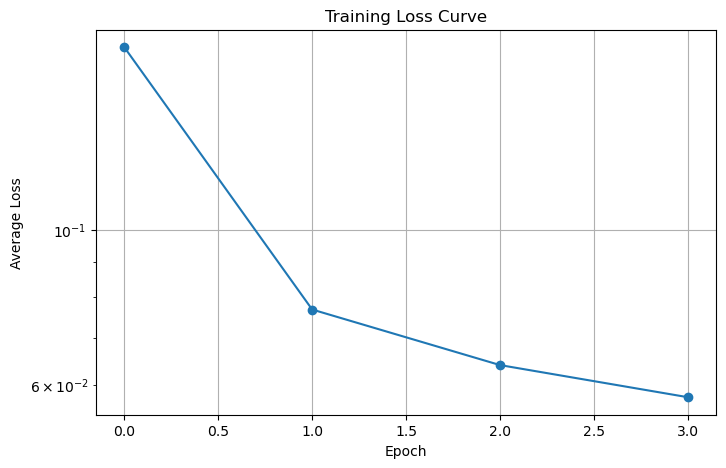

In [21]:
# More manual and tuneable MNIST training loop with Tensorflow / Keras
# Note that I will include a pure tensorflow version without the use of the Keras API,
# but this is no longer the standard way of developing production grade code.

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

def keras_custom_training():
    # Check for GPU
    device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
    print(f"Using device: {device}")

    # Hyperparameters
    learning_rate = 0.001
    weight_decay = 1e-4   # L2 regularization
    n_epochs = 20         # Maximum epochs
    batch_size = 64
    target_loss = 0.08    # Early stopping threshold
    patience = 3          # Consecutive epochs below threshold

    # Load and preprocess MNIST
    (x_train, y_train), _ = keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_train = x_train[..., None]  # (batch, 28, 28, 1)
    y_train = y_train.astype("int32")

    # Create dataset
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size)

    # Build CNN model manually using Functional API
    inputs = keras.Input(shape=(28, 28, 1))
    x = keras.layers.Conv2D(32, 3, padding="same", activation="relu",
                            kernel_regularizer=keras.regularizers.l2(weight_decay))(inputs)
    x = keras.layers.MaxPool2D(2, 2)(x)  # -> 14x14x32
    x = keras.layers.Conv2D(64, 3, padding="same", activation="relu",
                            kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    x = keras.layers.MaxPool2D(2, 2)(x)  # -> 7x7x64
    x = keras.layers.Flatten()(x)        # -> 3136
    x = keras.layers.Dense(128, activation="relu",
                        kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    outputs = keras.layers.Dense(10)(x)  # logits

    model = keras.Model(inputs, outputs)

    # Loss and optimizer
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Custom training loop
    loss_history = []
    consec_below = 0

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        batches = 0
        for batch_x, batch_y in train_ds:
            with tf.GradientTape() as tape:
                logits = model(batch_x, training=True)
                loss = loss_fn(batch_y, logits)
                # Add L2 losses
                loss += sum(model.losses)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss += loss.numpy()
            batches += 1

        avg_loss = epoch_loss / batches
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs} — Loss: {avg_loss:.4f}")

        # Early stopping check
        if avg_loss < target_loss:
            consec_below += 1
            if consec_below >= patience:
                print(f"Early stopping: {patience} epochs below {target_loss}.")
                break
        else:
            consec_below = 0

    print("Training complete!")

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.yscale("log")
    plt.grid(True)
    plt.show()

keras_custom_training()

Using device: GPU
Epoch 1/20 — Loss: 0.1740
Epoch 2/20 — Loss: 0.0654
Epoch 3/20 — Loss: 0.0526
Epoch 4/20 — Loss: 0.0474
Early stopping: 3 epochs below 0.08.
Training complete!


2025-06-23 13:32:22.441048: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


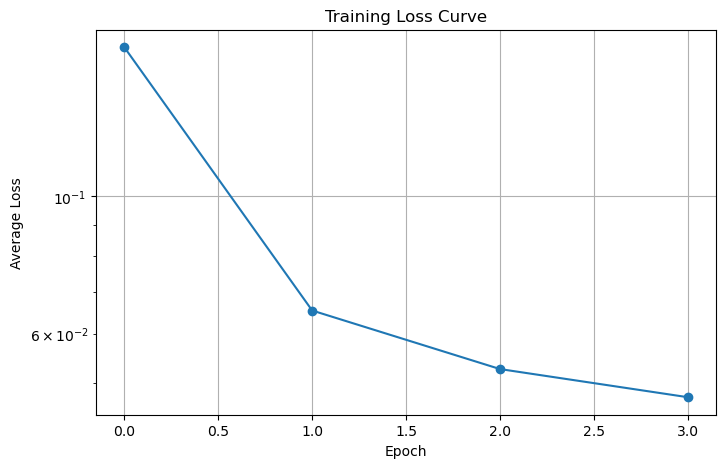

In [22]:
# Pure Tensorflow CNN training loop (not recommended but you can try it)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def tensorflow_training_loop():
    # 1. Check for GPU
    device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
    print(f"Using device: {device}")

    # 2. Hyperparameters
    learning_rate = 0.001
    weight_decay = 1e-4  # L2 regularization factor
    n_epochs = 20        # Maximum epochs
    batch_size = 64
    target_loss = 0.08   # Early stopping threshold
    patience = 3         # Consecutive epochs below threshold

    # 3. Load & preprocess MNIST (using tf.keras.datasets for convenience)
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, axis=-1)  # (batch, 28, 28, 1)
    y_train = y_train.astype("int32")

    train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                .shuffle(buffer_size=1024)
                .batch(batch_size))

    # 4. Define model weights and biases manually
    initializer = tf.initializers.GlorotUniform()
    # Conv1: 3x3 kernel, 1->32 channels
    W1 = tf.Variable(initializer(shape=[3, 3, 1, 32]), name="W1")
    b1 = tf.Variable(tf.zeros([32]), name="b1")
    # Conv2: 3x3 kernel, 32->64 channels
    W2 = tf.Variable(initializer(shape=[3, 3, 32, 64]), name="W2")
    b2 = tf.Variable(tf.zeros([64]), name="b2")
    # Dense1: flatten 7*7*64 -> 128
    W3 = tf.Variable(initializer(shape=[7*7*64, 128]), name="W3")
    b3 = tf.Variable(tf.zeros([128]), name="b3")
    # Dense2: 128 -> 10 logits
    W4 = tf.Variable(initializer(shape=[128, 10]), name="W4")
    b4 = tf.Variable(tf.zeros([10]), name="b4")

    # 5. Model forward function
    def model(x):
        # Conv1 + ReLU + MaxPool
        x = tf.nn.conv2d(x, W1, strides=1, padding="SAME") + b1
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding="SAME")  # -> 14x14x32
        # Conv2 + ReLU + MaxPool
        x = tf.nn.conv2d(x, W2, strides=1, padding="SAME") + b2
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding="SAME")  # -> 7x7x64
        # Flatten
        x = tf.reshape(x, [-1, 7*7*64])
        # Dense1 + ReLU
        x = tf.matmul(x, W3) + b3
        x = tf.nn.relu(x)
        # Dense2 (logits)
        logits = tf.matmul(x, W4) + b4
        return logits

    # 6. Loss function and optimizer
    loss_fn = lambda labels, logits: tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    ) + weight_decay * tf.add_n([tf.nn.l2_loss(v) for v in [W1, W2, W3, W4]])
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # 7. Custom training loop with early stopping
    loss_history = []
    consec_below = 0

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for batch_x, batch_y in train_ds:
            with tf.GradientTape() as tape:
                logits = model(batch_x)
                loss = loss_fn(batch_y, logits)
            grads = tape.gradient(loss, [W1, b1, W2, b2, W3, b3, W4, b4])
            optimizer.apply_gradients(zip(grads, [W1, b1, W2, b2, W3, b3, W4, b4]))
            epoch_loss += loss.numpy()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs} — Loss: {avg_loss:.4f}")

        if avg_loss < target_loss:
            consec_below += 1
            if consec_below >= patience:
                print(f"Early stopping: {patience} epochs below {target_loss}.")
                break
        else:
            consec_below = 0

    print("Training complete!")

    # 8. Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.yscale("log")
    plt.grid(True)
    plt.show()
    
tensorflow_training_loop()

Using device: cuda
Epoch 1/20 — Loss: 0.1747
Epoch 2/20 — Loss: 0.0527
Epoch 3/20 — Loss: 0.0384
Epoch 4/20 — Loss: 0.0301
Early stopping: 3 epochs below 0.08.
Training complete!


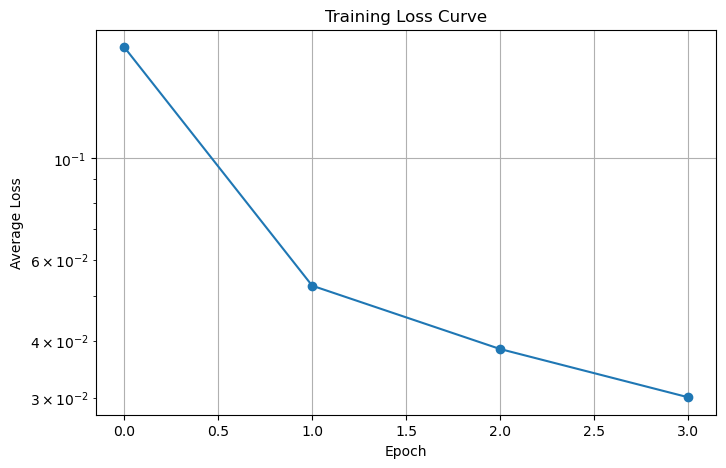

In [23]:
# Research grade simple CNN code using Pytorch

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 1. Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Hyperparameters
learning_rate = 0.001
weight_decay = 1e-4   # L2 regularization
n_epochs = 20         # Maximum epochs
batch_size = 64
target_loss = 0.08    # Early stopping threshold
patience = 3          # Consecutive epochs below threshold

# 3. Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),               # Convert to tensor (C,H,W) with values [0,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 4. Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # -> 7x7
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

model = SimpleCNN().to(device)

# 5. Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # includes softmax internally
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 6. Custom training loop with early stopping
loss_history = []
consec_below = 0

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = loss_fn(logits, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{n_epochs} — Loss: {avg_loss:.4f}")
    
    if avg_loss < target_loss:
        consec_below += 1
        if consec_below >= patience:
            print(f"Early stopping: {patience} epochs below {target_loss}.")
            break
    else:
        consec_below = 0

print("Training complete!")

# 7. Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(loss_history, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.yscale("log")
plt.grid(True)
plt.show()

# Additional Optimizations

Now that we're accustomed to the traditional CNN pipeline, we have scratched the surface of an iceberg of techniques that modern CNNs use in practice.

- While the fundamental idea and general structure of CNNs is consistent throughout most approaches, several optimizations can be made in any stage of the training loop.

Some of these techniques include:

- **Dropout Layers**: Randomly zero out some features in a feature map to prevent overfitting
- **Batch Normalization**: Use the statistical mean and variance across a batch of inputs to normalize the outputs in a feature map before applying ReLU.
- **Data Augmentation**: Apply random transformations to input images such as cropping, flipping, or color filters, to ensure that the network learns the concept without relying or being biased in determining classes based on the location or color of features.
- **Global Pooling**: Instead of feeding sequential flattened feature maps for classification, we could apply one last pooling layer beforehand to generate a singular value per feature and use those for classification.
- **Skip Connections**: We can use a parameter to allow the output from one layer to skip some of the next layers and feed directly as the input for these deeper layers.

---

## Dropout Layers

The intuition behind using dropout layers is that we seek to randomly zero out the presence of some features in a feature map.

- Dropout layers act as another form of regularization because they offer a tradeoff between bias and variance similar to L1 and L2 regularization.

Mathematically:

$$y = W * x$$

is the typical weighted sum that describes the main operation conducted prior to applying non-linearity.

We can apply a mask to the inputs as follows:

$$y=W⋅(M⊙x)$$

Where $M$ is a mask and $⊙$ is elementwise multiplication.

These layers can be thought of as a mask on top of the inputted feature maps that is applied prior to calculating the activation of the layer.
We do not want to apply this technique directly to image data because that would corrupt the actual data in the image itself, **but applying it between convolutional layers or even between fully connected layers that work with the feature maps (not the image data) can be beneficial.**

Dropout layers are used to address and prevent the problem of **overfitting** (prevent the model from "memorizing" the data):

- Because downsampling techniques like **strided convolution and pooling already address many overfitting concerns, dropout is rarely applied in the convolutional stack** in modern models.

- Instead, dropout layers are more frequently used between fully connected layers since that portion of a CNN is more prone to overfitting without them.

- Each time we pass a training image or batch of images, we are slightly tweaking the network by randomly selecting what neurons to drop.

- - In essence we are **training slightly different networks with each forward pass**, and we take one simple step at the end to average out the results of training across them.

**Dropout layers can be added between convolutional layers, but are more often used in the classification pipeline, between fully connected dense layers.**

The impact of dropout’s random deactivations is automatically compensated for, so that at test time no further adjustments are needed.

- If some fraction, **$p$, of the activations are zeroed out randomly in each forward TRAINING pass**, we have to scale up the remaining activations to keep the expected output value in a consistent range.

- **The remaining activations are scaled up by $\frac{1}{1 - p}$**

**During testing, dropout is deactivated, meaning no neurons are dropped**.

- The scaling that happened during training ensures that the outputs are already calibrated. This means no need for further adjustment at test time.

In modern frameworks like Pytorch and Tensorflow, the **dropout layers automatically behave differently under training and testing environments.**

For example:

Suppose $p = 25\%$, meaning 25% of the neurons are deactivated in a dropout layer during training.

- During training, the dropout layer will apply this multiplier to the remaining living neurons: $\frac{1}{(1 - 0.25)}$
- This scale up ensures that the magnitude of the activations remains consistent during training and testing (during which no neurons are deactivated).

---

**In convolutional layers, applying dropout means zeroing out entire channels (feature maps), not individual neurons within a map.**

- This is sometimes called **spatial dropout or Dropout2d**.

- Zeroing out entire channels **does not affect dimensionality: the input retains the same number of channels, but some contain only zeros during that pass**.

- For example, if the input has 16 channels, **we randomly select entire feature maps to zero out, not individual features within them.**

In [24]:
# A Basic CNN in pytorch built with one dropout layer in the convolutional stack and one dropout layer in the classifier stack
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary


class CNNWithDropout(nn.Module):
    def __init__(self, n_classes = 10):
        super(CNNWithDropout, self).__init__()
        
        # Assumptions:
            # Input is 32 by 32
            # Everywhere here the stride length is 1, and the padding is 1, which means
            # the feature maps DO NOT change in terms of spatial size compared to the original
            # dimensions of the image.
            # The input and output dimensions are PER image. However the number of images
            # (i.e. batch size) per pass is the 0th dimension even though its never explicitly shown.
        
        # Define the convolutional stack
        
        # Two convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1) # Input = [32, 32, 3], Output = [32, 32, 32]
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1) # Input = [32, 32, 32], Output = [64, 32, 32]
        
        # One pooling layer
        self.pool = nn.MaxPool2d(2, 2) # This pooling layer will turn halve the spatial size of each channel: Input = [64, 32, 32], Output = [64, 16, 16]
        
        # One dropout layer with p = 0.25
        self.dropout_conv = nn.Dropout2d(p = 0.25) # Dropout layers don't affect the shape of the data because they randomly zero out a set portion of the feature maps.
        
        # Define the classification stack
        
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        
        self.dropout_fc = nn.Dropout(p = 0.5) # Similarly this dropout layer does not change the shape of the data,
        
        self.fc2 = nn.Linear(128, n_classes) # Each of the prior 128 neurons connects to the last layer which contains raw logits for classification
        
    def forward(self, x):
        
        # Pass through the convolution stack and apply appropriate activations (ReLU) along the way
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        # Flatten the final feature set but leave the 0th dimension (the batch size, i.e. the "invisible dimension")
        x = torch.flatten(x, start_dim=1)
        
        # Pass through the classification stack and apply appropriate activations (ReLU) along the way
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x) # Apply the dropout between the fully connected layers
        x = self.fc2(x)
        
        return x

model = CNNWithDropout(n_classes=10)
summary(model, input_size=(16, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNNWithDropout                           [16, 10]                  --
├─Conv2d: 1-1                            [16, 32, 32, 32]          896
├─Conv2d: 1-2                            [16, 64, 32, 32]          18,496
├─MaxPool2d: 1-3                         [16, 64, 16, 16]          --
├─Dropout2d: 1-4                         [16, 64, 16, 16]          --
├─Linear: 1-5                            [16, 128]                 2,097,280
├─Dropout: 1-6                           [16, 128]                 --
├─Linear: 1-7                            [16, 10]                  1,290
Total params: 2,117,962
Trainable params: 2,117,962
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 351.30
Input size (MB): 0.20
Forward/backward pass size (MB): 12.60
Params size (MB): 8.47
Estimated Total Size (MB): 21.27

**In the code above we used an auxillary library, `torchinfo`, in order to get an understanding of how data flows through our model and the size of the model itself, both in terms of parameters and physical storage size.**

- The summary reveals that a vast majority of the parameters in our model originate from the linear layer located towards the end of the pipeline.

- - This is very common among traditional CNN models.

This is one reason why dropping some of these features in the classification stage is often more impactful than dropping parameters between convolutional layers!

---

## Batch Normalization

Right now the data we are passing through the model is passed along in batched, often in batches of 32 or 64.

- Recall that an *epoch* is how long it takes for all of the training data (which is chunked into batches) to make one pass through the model.

However we can apply a simple technique to stabilize the results computed by each batch through each layer.

- In basic statistics we learn the following:
    - the mean of a set of values tells us its central tendency,
    - the variance (or standard deviation) tells us how spread-out those values are.

Batch Normalization (BatchNorm) takes advantage of these statistics at each layer, for each channel, to keep activations well-behaved. 
Here’s how it works, step by step, for a single feature map (channel) in a single layer:

1) For a given channel, over a batch of size B and spatial dimensions H×W, we collect all the activations (all the outputs in the feature map, after applying ReLU)

$$\{x_{i,j,k}\}, \space i = 1 \ldots B, \space j = 1 \ldots H, \space k = 1 \ldots W$$

- - $B$ is the batch size.
- - $H$ and $W$ are the image dimensions (height and width in pixels).

2) Compute the statistical mean and variance of the batch

$$\mu_{\text{batch}} = \frac{1}{B \cdot H \cdot W} \Sigma_{i, j, k}x_{i, j, k}$$

$$\sigma^2_{batch} = \frac{1}{B \cdot H \cdot W} \Sigma_{i, j, k}(x_{i, j, k} - \mu_{batch})^2$$

3) Use the computed values to normalize the scores. This is done by subtracting the mean and dividing by the variance.

$$\hat{x}_{i, j, k} = \frac{x_{i, j, k} - \mu_{\text{batch}}}{\sqrt{\sigma^2_\text{batch} +\epsilon}}$$

(This formula is applied to each score)

Note that the **role of $\epsilon$ is to apply a lower bound to the denominator** in case $\sigma^2_\text{batch}$ is so small that it is rounded to zero.

$$\sqrt{\sigma^2 + e} \ge \sqrt{\epsilon}$$

- **The $\epsilon$ value is hyperparameter that helps account for numerical instability**. We set it to a non-zero value to avoid division by zero errors.
- - We can choose to use relatively high values for $\epsilon$ such as $0.001$ or $0.0001$ if we see exploding gradients or division by zero errors often. Higher values for $\epsilon$ aggresively normalizes activations to be closer to zero but this may reduce the range of gradients too directly.
- - A smaller $\epsilon$ keeps the effect of the variance more faithfully and is generally preferred if you have enough computer precision to avoid zeroing out the denominator.



4) Batch normalization goes beyond basic standardizing and applies further transformations to the normalized score.

- The prior normalized scores, $\hat{x}_{i, j, k}$, are scaled and shifted using two hyperparameters: $\gamma$ and $\beta$

$$y_{i, j, k} = \gamma \hat{x}_{i, j, k} + \beta$$

The two hyperparameters are trained using backpropogation alongside the rest of the model.

4) During training we keep track of an exponential moving average of mean ($\mu_{\text{batch}}$) and variance $(\sigma^2_{batch})$ across all samples using a momentum parameter.

- **At test time use the running averages instead of the current batch's mean and variance.**

Lets understand what this means for test time (i.e. when running the model in `model.eval()` mode)

The exponential moving average for mean and variance are updated after processing some batch $t$ as follows:

$$\operatorname{EMA}_{\mu}^{t + 1} = (1 - \alpha) \cdot r_{\mu}^{(t)} + \alpha \mu^{(t)}$$
$$\operatorname{EMA}_{\sigma^2}^{t + 1} = (1 - \alpha) \cdot r_{\sigma^2}^{(t)} + \alpha \sigma^{2(t)}$$

- Note that in the $t$ is not a parameter, it is just to indicate the nth term. So the second equation where it is written $\sigma^{2(t)}$ DOES NOT INDICATE that we are multiplying some $t$ by 2, it is simply an indicator.

- **$\alpha$ is a momentum hyperparameter**
- - A large $\alpha$ means that newer, more recent, values are given more weight in calculating the EMA.
- - A small $\alpha$ means that change is slower to adapt to new data but also smoother over time.

**The key insight is that in testing mode we use the finalized version of these EMAs from training instead of per batch values**

$$\hat{x}_{i, j, k} = \frac{x_{i, j, k} - \operatorname{EMA}_{\mu}}{\sqrt{\operatorname{EMA}_{\sigma^2} +\epsilon}}$$

Of course, afterwards this estimate is then scaled as described in step 4:

$$y_{i, j, k} = \gamma \hat{x}_{i, j, k} + \beta$$

- This technique is practically identical to the ADAM (Adaptive Momentum) strategy that can be used to regularize gradient descent.

**It is very important to understand that after the training process, all parameters: $\operatorname{EMA}_{\mu}, \operatorname{EMA}_{\sigma^{2}}, \gamma, \beta$ are all frozen.**

- **We never update these parameters in the testing phase, we simply use the finalized versions of these parameters from training.**

### In Practice

The process described prior involves tuning and testing the *$\alpha$* (momentum) and *$\epsilon$* (instability) hyperparameters.

**By default the value of $\epsilon$ in PyTorch and Tensorflow is $0.00001$**

The step of applying and training *affine* parameters to scale the activation after it has been normalized ($y_{i, j, k} = \gamma \hat{x}_{i, j, k} + \beta$) is optional.

- The scale and shift step is also more mathematically definable as an *affine transformation* by definition:

- - A linear map must have the form $y = mx$ which always passes through the origin

- - An affine map is simply a linear map with a constant shift: $y = mx + b$.

- The *affine* step can be disabled by setting `affine = false` in the batch norm layer.

Here are some general guidelines:

- If your batch size is large (64 or greater), a higher value of $\alpha$ (0.2-0.4) is useful to ensure that the running statistics recall trends from prior batches.

- If your batch size is small (16 or lesser), a smaller value of $\alpha$ (0.01-0.1) helps in getting smoother estimates and avoiding batch to to batch instability.

- If you see exploding activations try increasing $\epsilon$ to values a little larger values $0.0001$ or $0.001$.

- **Batch normalization should be applied after determining the efects of the convolution, but before applying the ReLU activation function.**

- Skip batch norm on the final classification layer (or use sparingly), since you don’t usually want to normalize logits.

Of course none of this advice is perfect and toying around with these statistics to see which experiment provides the best outcomes for the particular data is always required!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader

# 1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST('.', train=True,  transform=transform, download=True)
test_ds  = datasets.MNIST('.', train=False, transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

# 3) Models
class TinyNoBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1   = nn.Linear(32*7*7, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = F.max_pool2d(x,2)
        x = F.relu(self.conv2(x)); x = F.max_pool2d(x,2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class TinyWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(32)
        self.fc1   = nn.Linear(32*7*7, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))); x = F.max_pool2d(x,2)
        x = F.relu(self.bn2(self.conv2(x))); x = F.max_pool2d(x,2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# 4) Train & Eval routines
def train_epoch(model, loader, opt, criterion):
    model.train()
    total_loss = 0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        opt.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        opt.step()
        total_loss += loss.item()*X.size(0)
    return total_loss/len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(device), y.to(device)
            out = model(X)
            total_loss += criterion(out,y).item()*X.size(0)
            pred = out.argmax(dim=1)
            correct += pred.eq(y).sum().item()
    return total_loss/len(loader.dataset), correct/len(loader.dataset)

# 5) Run experiment
def run_test(model_cls, name):
    model = model_cls().to(device)
    opt   = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    crit  = nn.CrossEntropyLoss()
    for epoch in range(3):
        train_loss = train_epoch(model, train_loader, opt, crit)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print(f"{name:>10s}  Test Loss: {test_loss:.4f}  Test Acc: {test_acc*100:5.2f}%")

run_test(TinyNoBN, "No BatchNorm")
run_test(TinyWithBN, "With BatchNorm")

No BatchNorm  Test Loss: 0.0417  Test Acc: 98.58%
With BatchNorm  Test Loss: 0.0465  Test Acc: 98.64%


## Data Augmentation

Data augmentation is by far the most straightforward yet potentially intricate ways to improve the robustness of any AI model.

- The hypothesis: Perhaps the data fed into the model is not representative of an imperfect, real world, dataset. Therefore, when met with imperfect data the model may fail to achieve performance on par with its testing loop.

- The solution: We can artifically apply transformations to portions of the training data to force the model to learn from imperfect examples that are more representative of real world data.

Various types of adjustments can be made to visual data:

| Type                        | Example                                     | Purpose                                |
| --------------------------- | ------------------------------------------- | -------------------------------------- |
| **Geometric**               | Flips, rotations, translations, cropping    | Invariance to position/orientation     |
| **Color/Lighting**          | Brightness, contrast, saturation, hue shift | Invariance to illumination             |
| **Noise/Blur**              | Gaussian noise, motion blur                 | Robustness to imperfect images         |
| **Scaling**                 | Zoom in/out                                 | Invariance to object size              |
| **Cutout / Random erasing** | Mask out random patches                     | Force focus on global features         |
| **Mixup / CutMix**          | Combine pairs of images & labels            | Encourage smoother decision boundaries |

Beyond simple visual data:

- We can make adjustments to written data by replacing words with synonyms, translating to other languages or slang, or randomly inserting / deleting words or phrases.
- We can also transform audio data by applying shifting, pitch scaling, or adding / removing distortion or background noise.

This list of transformations is by no means exhaustive but should inform you on how data diversity can be achieved by generating synthetic, modified, inputs from the original data.

`torchvision` is a library which contains the `transforms` package to quickly define a set of transformations which can be applied to a dataset.

Here is some example code:

In [27]:
import torchvision.transforms as T

# Compose several augmentations together
transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop(32, scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomRotation(15),
    T.ToTensor(),
])

# Apply this to your dataset
from torchvision.datasets import CIFAR10
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)

100.0%


Of course **we should not train our model so much on imperfect data that the model becomes confused regarding classification tasks**.

- It is important to ensure diversity in the data without doing so in an unrealistic way.

Ex. Rotating 20% of the digits in the MNIST dataset by 180 degrees.

- Ask yourself, in the real world, what percentage of people write their numbers upside down? Is it anywhere near the percentage of misleading data we are provided the model?

- The bottom line: **Don’t just randomly apply all augmentations, instead try to use transformations your model will need to handle in deployment.**

### Mixup Augmentation

One specialized non-geometric way that we can choose to modify our dataset is to pair up and combine two inputs to synthesize a new image.

*Mixup* is a technique that samples two random images and their respective labels and combines then combines them based on a weighted parameter: $\lambda$.

For one pair of input and label $(x_i, y_i)$ and another input and label $(x_j, y_j)$ we can combine them as follows

$$x_{\text{combined}} = \lambda \cdot x_i + (1 - \lambda) x_j$$
$$y_{\text{combined}} = \lambda \cdot y_i + (1 - \lambda) y_j$$

**The weight parameter $\lambda$ is randomly drawn from a beta distribution with a mean and variance of $\alpha$ (which is typically some value from $0.1-0.4$)**

$$\lambda ∼ \operatorname{Beta}(\alpha, \alpha)$$

The following is a direct quote from the original paper that proposed the *mixup* technique:

```text

"While data augmentation consistently leads to improved generalization (Simard et al., 1998), the procedure is dataset-dependent, and thus requires the use of expert knowledge. Furthermore, data augmentation assumes that the examples in the vicinity share the same class, and does not model the vicinity relation across examples of different classes."

Source:
    
    mixup: Beyond Empirical Risk Minimization (Zhang, Cisse, et. al)

```

Traditional data augmentation methods (e.g. rotation, flipping, cropping) work by generating new examples that are small transformations of existing ones.

- These methods rely on the assumption that such transformations preserve the label.
- But this assumption:
- - **Requires dataset-specific knowledge** (e.g. what transformations are safe to apply)
- - Can **break down for ambiguous or similar classes**

Consider the example:

- The digits 6 and 9 can be transformed into one another by a simple 180-degree rotation.

- If you apply **180-degree rotation as a data augmentation blindly, you risk turning a correctly labeled 6 into something that looks like a 9 → introducing label noise unintentionally.**

Mixup smoothly blends between classes in a principled way. It explicitly models vicinity across examples of different classes (e.g. what a sample that’s 70% cat and 30% dog should look like).

The benefits of Mixup include:

- **Dataset agnostic:** No need for expert domain knowledge to choose safe augmentations.

- **Reduces overfitting:** Encourages the model to behave linearly between training samples.

- **Robustness:** Improves resistance to adversarial examples and noisy labels.

- **Smooth decision boundaries:** Instead of sharp transitions between classes, the model learns gradual transitions, improving generalization.

In [ ]:
# Code example of how to apply Mixup to a batch of data points

def mixup_data(x, y, alpha=0.2):
    
    # Sample lambda from a Beta distribution to determine the mix ratio
    lam = np.random.beta(alpha, alpha)
    
    # Get the number of samples in the batch
    batch_size = x.size(0)
    
    # Generate a random permutation of the batch indices for pairing
    # Example: for batch indices [0, 1, 2, 3], this could produce [2, 0, 3, 1]
    index = torch.randperm(batch_size)

    # Mix each input with its randomly paired input
    # Example: x[0] mixes with x[2], x[1] mixes with x[0], etc.
    mixed_x = lam * x + (1 - lam) * x[index, :]

    # Pair the labels for later use in the mixed loss calculation
    # We don’t mix the labels here numerically because the model’s prediction
    # is needed to compute loss first (the mixing happens in the loss function)
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

# Example usage in training:
pred = model(mixed_x)  # Make predictions on the mixed inputs

# Compute the mixed loss: the model is encouraged to output a blend matching the input mix
loss = lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

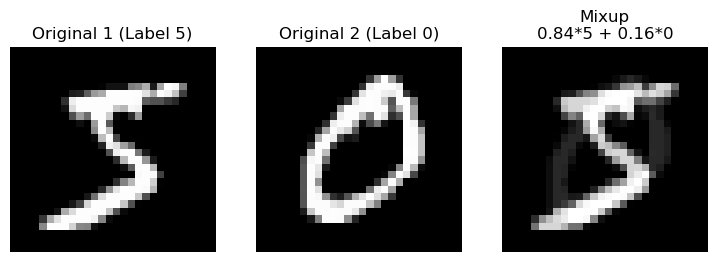

Mixup loss: 1.5127
Mixed prediction probs: [[1.3689329e-03 2.6107987e-04 3.3764855e-03 3.8774496e-01 5.8602295e-06
  5.9345216e-01 1.7844657e-04 2.0511993e-03 1.1347534e-02 2.1333095e-04]]


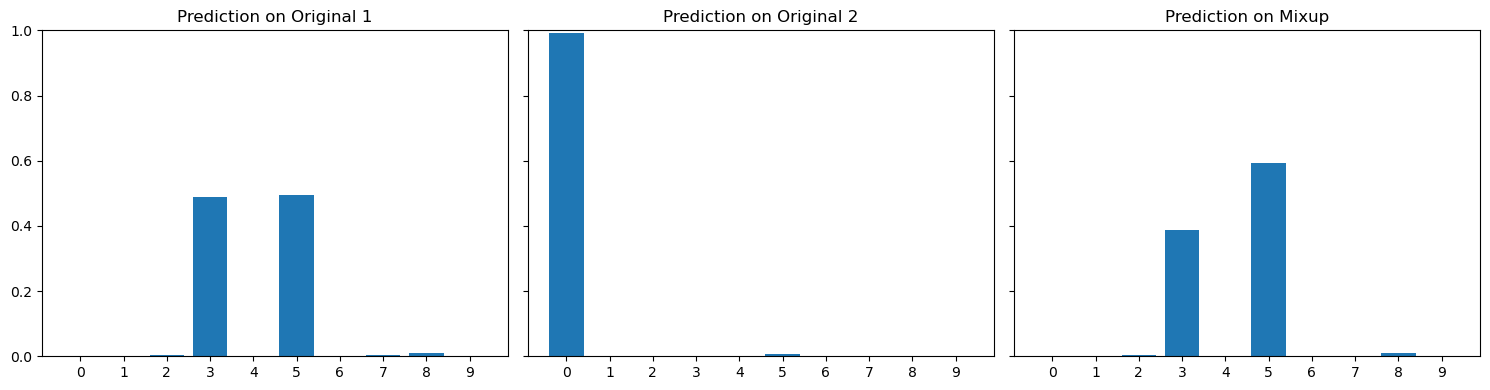

In [50]:
# A visual demonstration of how two inputs can get mixed up:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1️) Load two MNIST samples
# -------------------------
transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

x1, y1 = mnist[0]  # Example 1
x2, y2 = mnist[1]  # Example 2

# -------------------------
# 2️) Mixup the two samples
# -------------------------
alpha = 0.4
lam = np.random.beta(alpha, alpha)

mixed_x = lam * x1 + (1 - lam) * x2

# -------------------------
# 3️) Display side-by-side, bigger images
# -------------------------
def show_images(x1, x2, mixed_x, y1, y2, lam):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(x1.squeeze().numpy(), cmap='gray')
    axs[0].set_title(f'Original 1 (Label {y1})')
    axs[0].axis('off')

    axs[1].imshow(x2.squeeze().numpy(), cmap='gray')
    axs[1].set_title(f'Original 2 (Label {y2})')
    axs[1].axis('off')

    axs[2].imshow(mixed_x.squeeze().numpy(), cmap='gray')
    axs[2].set_title(f'Mixup\n{lam:.2f}*{y1} + {1 - lam:.2f}*{y2}')
    axs[2].axis('off')

    plt.show()

show_images(x1, x2, mixed_x, y1, y2, lam)

# -------------------------
# 4️) Define a quick model
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(32 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------
# 5️) Quick train on MNIST subset so model has some idea
# -------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

loader = DataLoader(mnist, batch_size=64, shuffle=True)
model.train()
for batch_idx, (data, target) in enumerate(loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx > 100:  # quick 100 batches for speed
        break

# -------------------------
# 6️) Run predictions on originals + mixed
# -------------------------
model.eval()
x1 = x1.unsqueeze(0).to(device)
x2 = x2.unsqueeze(0).to(device)
mixed_x = mixed_x.unsqueeze(0).to(device)

with torch.no_grad():
    pred1 = model(x1)
    pred2 = model(x2)
    pred_mixed = model(mixed_x)

# -------------------------
# 7) Compute mixup loss
# -------------------------
y_a = torch.tensor([y1]).to(device)
y_b = torch.tensor([y2]).to(device)

loss_mixed = lam * criterion(pred_mixed, y_a) + (1 - lam) * criterion(pred_mixed, y_b)
print(f"Mixup loss: {loss_mixed.item():.4f}")

# Optionally, view predicted probabilities
probs = F.softmax(pred_mixed, dim=1).cpu().numpy()
print(f"Mixed prediction probs: {probs}")

# -------------------------
# 8) Visualize change in predicted probabilities by combining two samples
# -------------------------

# Compute softmax probabilities
probs1 = F.softmax(pred1, dim=1).cpu().numpy().flatten()
probs2 = F.softmax(pred2, dim=1).cpu().numpy().flatten()
probs_mixed = F.softmax(pred_mixed, dim=1).cpu().numpy().flatten()

# Plot bar charts
def plot_probabilities(probs1, probs2, probs_mixed):
    classes = np.arange(10)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    axs[0].bar(classes, probs1)
    axs[0].set_title('Prediction on Original 1')
    axs[0].set_xticks(classes)
    axs[0].set_ylim(0, 1)

    axs[1].bar(classes, probs2)
    axs[1].set_title('Prediction on Original 2')
    axs[1].set_xticks(classes)

    axs[2].bar(classes, probs_mixed)
    axs[2].set_title('Prediction on Mixup')
    axs[2].set_xticks(classes)

    plt.tight_layout()
    plt.show()

plot_probabilities(probs1, probs2, probs_mixed)


### CutMix Augmentation

If mixup augments data by combining two images and their criterion holistically, then CutMix augmentation combines data by cutting out and repatching portions of an image into another image.

- This is accomplished in a very similar fashion to the idea of applying a mask in Drop Out layers. However, instead of just neutralizing values by zeroing them out, we use two inverse masks on two samples to effective cut one portion of an image into the same region of another image.

To understand how this is accomplished lets first tackle the idea of "masking" more generally.

Consider the mask: 

$$ A =
\begin{bmatrix}
1 & 1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
$$

If we performed element wise multiplication between this mask and an image, only the top left corner of the image would be preserved.

- **How could we accomplish the opposite? (preserve everything except the top left of the 5 by 5 image)**

- Well we could simply calculate $1 - A$ where $1$ expands to a 5 by 5 matrix filled with 1s.

$$ 1 - A =
\begin{bmatrix}
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
-
\begin{bmatrix}
1 & 1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
=
\begin{bmatrix}
0 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
$$

We could extract the top left patch from some image $x_1$ and the residual (everything except the top left patch) from some image $x_2$ and combine the two images as follows:

$$x_{\text{combined}} = A \odot x_1 + (1 - A) \odot x_2$$

- $\odot$ is the element-wise multiplication operator.

We could apply similar logic to combine the classification labels of the two respective labels (i.e. their final )